In [120]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

import shap
from lime.lime_tabular import LimeTabularExplainer

import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
data = pd.read_csv('bank-additional-full.csv', sep = ';')
data.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

### Предобработка данных

In [28]:
data.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

In [30]:
data.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [32]:
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [34]:
data.duplicated().sum()

12

In [36]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [38]:
obj_columns = list(data.select_dtypes('object').columns)

In [40]:
for i in ['job','month','day_of_week', 'education', 'y']:
    obj_columns.remove(i)

obj_columns

['marital', 'default', 'housing', 'loan', 'contact', 'poutcome']

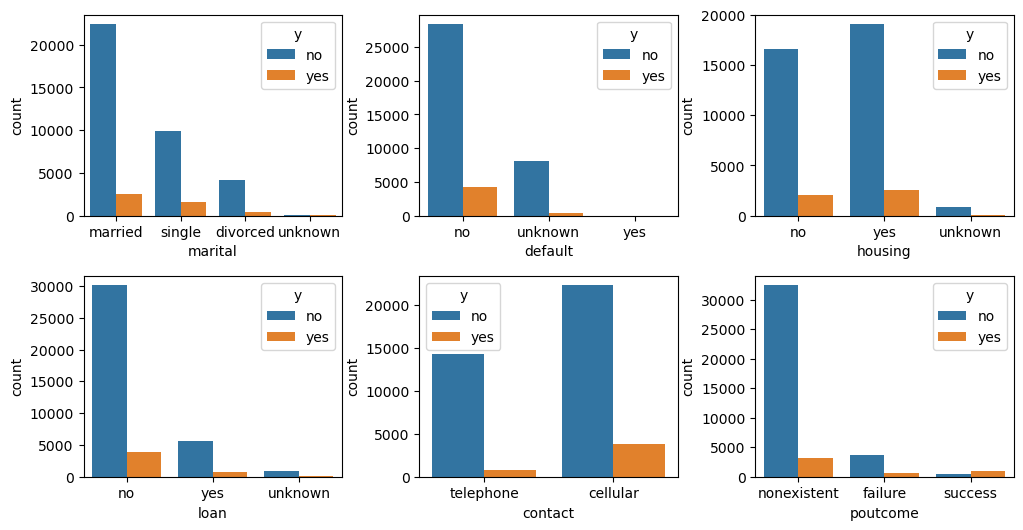

In [42]:
fig = plt.subplots(2, 3, figsize = (12,6))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(len(obj_columns)):
    plt.subplot(2,3,i+1)
    sns.countplot(data, x = obj_columns[i], hue = 'y')
plt.show()

<Axes: xlabel='y', ylabel='count'>

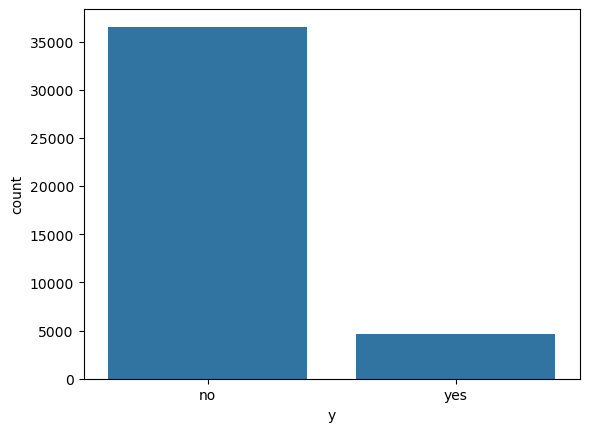

In [43]:
sns.countplot(data, x = 'y')

In [44]:
data = data.drop(['day_of_week', 'month'], axis = 1)

In [47]:
data.y = data.y.apply(lambda x: 0 if x=='no'\
                  else 1)

data.contact = data.contact.apply(lambda x: 0 if x == 'telephone'\
                                  else 1)

data.job = data.job.apply(lambda x: -1 if x == 'unknown'\
                          else 1 if x == 'unemployed'\
                          else 2 if x == 'housemaid'\
                          else 3 if x == 'services'\
                          else 4 if x == 'admin.'\
                          else 5 if x == 'blue-collar'\
                          else 6 if x == 'technician'\
                          else 7 if x == 'retired'\
                          else 8 if x == 'management'\
                          else 9 if x == 'self-employed'\
                          else 10 if x == 'entrepreneur'\
                          else 11)

data.marital = data.marital.apply(lambda x: -1 if x == 'unknown'\
                                 else 1 if x == 'married'\
                                 else 2 if x == 'single'\
                                 else 3)

data.education = data.education.apply(lambda x: -1 if x == 'unknown'\
                                     else 1 if x in ('basic.4y', 'basic.6y', 'basic.9y')\
                                     else 2 if x == 'high.school'\
                                     else 3 if x == 'professional.course'\
                                     else 4 if x == 'university.degree'\
                                     else 5)

data.default = data.default.apply(lambda x: 0 if x == 'no'\
                              else 1 if x=='yes'\
                              else -1)

data.housing = data.housing.apply(lambda x: 0 if x == 'no'\
                              else 1 if x == 'yes'\
                              else -1)

data.loan = data.loan.apply(lambda x: 0 if x == 'no'\
                        else 1 if x == 'yes'\
                        else -1)

data.poutcome = data.poutcome.apply(lambda x: 0 if x == 'failure'\
                                else 2 if x == 'success'\
                                else -1)

data.pdays = data.pdays.apply(lambda x: -1 if x==999\
                          else 1 if x<=10\
                          else 2 if x<=20\
                          else 3)

In [50]:
data_columns = data.columns

In [52]:
n_scaler = MinMaxScaler()
data_norm = n_scaler.fit_transform(data)

data = pd.DataFrame(data_norm, columns = data_columns)
data.head()

age       job  marital  education  default  housing  loan  contact  \
0  0.481481  0.250000      0.5   0.333333      0.5      0.5   0.5      0.0   
1  0.493827  0.333333      0.5   0.500000      0.0      0.5   0.5      0.0   
2  0.246914  0.333333      0.5   0.500000      0.5      1.0   0.5      0.0   
3  0.283951  0.416667      0.5   0.333333      0.5      0.5   0.5      0.0   
4  0.481481  0.333333      0.5   0.500000      0.5      0.5   1.0      0.0   

   duration  campaign  pdays  previous  poutcome  emp.var.rate  \
0  0.053070       0.0    0.0       0.0       0.0        0.9375   
1  0.030297       0.0    0.0       0.0       0.0        0.9375   
2  0.045954       0.0    0.0       0.0       0.0        0.9375   
3  0.030704       0.0    0.0       0.0       0.0        0.9375   
4  0.062424       0.0    0.0       0.0       0.0        0.9375   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed    y  
0        0.698753        0.60251   0.957379     0.859735  0.0  
1        0.698753        0.60251   0.957379     0.859735  0.0  
2        0.698753        0.60251   0.957379     0.859735  0.0  
3        0.698753        0.60251   0.957379     0.859735  0.0  
4        0.698753        0.60251   0.957379     0.859735  0.0

### Обучение модели градиентного бустинга

In [55]:
X = data.drop('y', axis = 1)
y = data.y

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=0)

In [59]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)

print(f'LightGBM Accuracy: {round(accuracy_score(y_test, lgbm_pred), 2)*100}')

[LightGBM] [Info] Number of positive: 3583, number of negative: 28534
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 32117, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111561 -> initscore=-2.074896
[LightGBM] [Info] Start training from score -2.074896
LightGBM Accuracy: 92.0


### Beeswarmplot & Waterfall

In [69]:
explainer = shap.Explainer(lgbm, X)
shap_values = explainer(X)

100%|===================| 41171/41176 [01:58<00:00]        

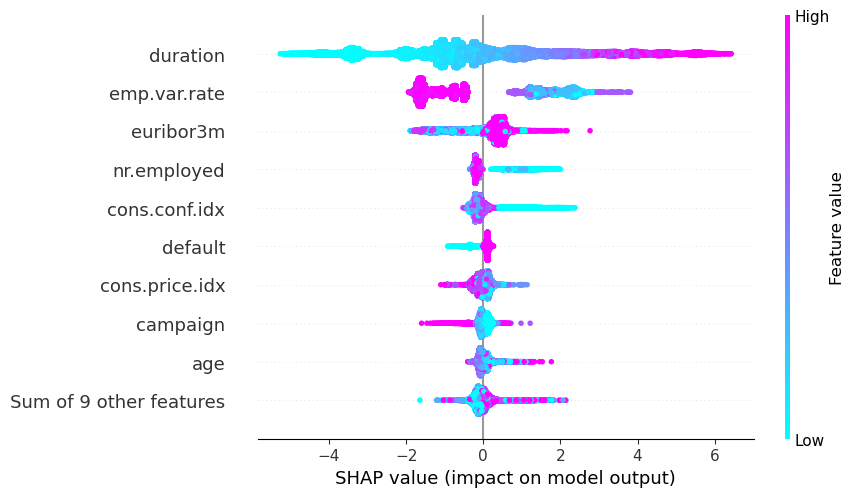

In [71]:
shap.plots.beeswarm(shap_values, color=plt.get_cmap("cool"))

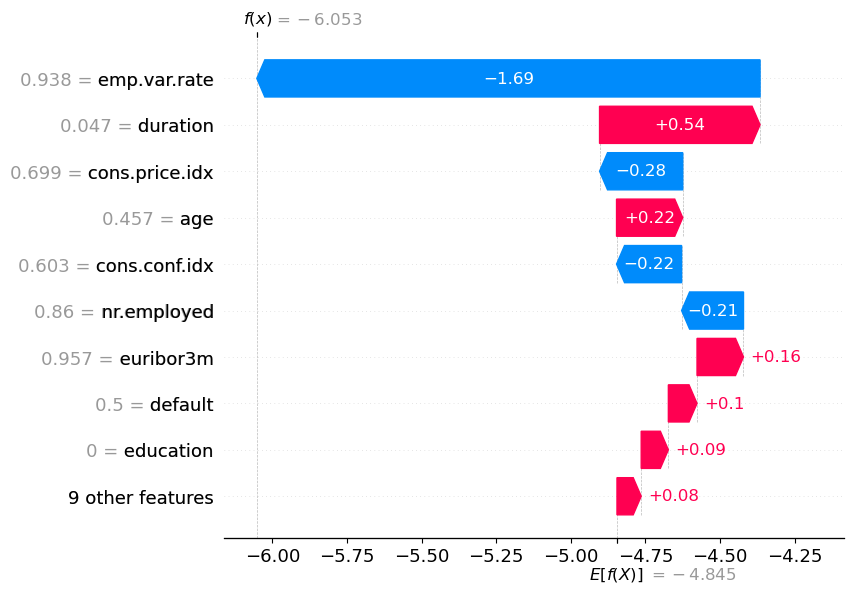

In [109]:
shap.plots.waterfall(shap_values[100])

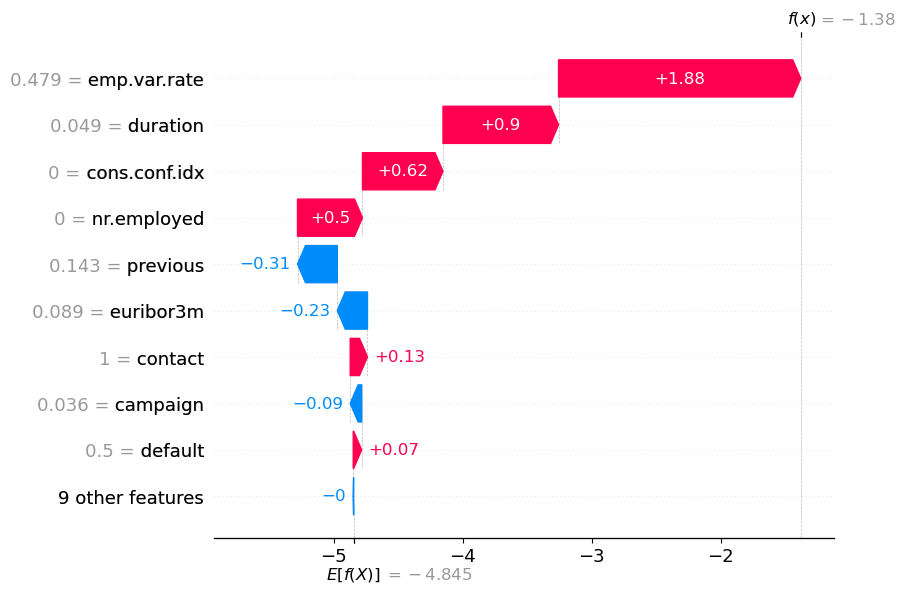

In [105]:
shap.plots.waterfall(shap_values[41175])

### LIME

In [134]:
features = X_train.columns.tolist()

explainer = LimeTabularExplainer(X_train.values, 
                                 feature_names = features, 
                                 class_names = ['0', '1'], 
                                 mode = 'classification')

In [175]:
instance = X_test.iloc[1]
explanation = explainer.explain_instance(instance.values, lgbm.predict_proba, num_features = len(features))

explanation.show_in_notebook(show_table=True)

In [178]:
instance = X_test.iloc[55]
explanation = explainer.explain_instance(instance.values, lgbm.predict_proba, num_features = len(features))

explanation.show_in_notebook(show_table=True)

In [159]:
instance = X_test.iloc[1000]
explanation = explainer.explain_instance(instance.values, lgbm.predict_proba, num_features = len(features))

explanation.show_in_notebook(show_table=True)

In [157]:
instance = X_test.iloc[4529]
explanation = explainer.explain_instance(instance.values, lgbm.predict_proba, num_features = len(features))

explanation.show_in_notebook(show_table=True)

In [155]:
instance = X_test.iloc[9058]
explanation = explainer.explain_instance(instance.values, lgbm.predict_proba, num_features = len(features))

explanation.show_in_notebook(show_table=True)